In [39]:
# Add imports here
!pip install imbalanced-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
# Loading and "cleaning" data
df = pd.read_csv("California-Wildfire-Data.csv")
df_obj = df.select_dtypes("object")

df_obj.head()

C:\Users\Advait\AppData\Local\Temp\ipykernel_27480\1426229991.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("California-Wildfire-Data.csv")


,* Damage,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,...,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,APN (parcel),Site Address (parcel),GLOBALID
0,Destroyed (>50%),unknown,Road,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,"Mesh Screen <= 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,11616045,NaN,ce752f2c-dea2-4647-b0cd-e4ed01f8619d
1,Destroyed (>50%),unknown,Road,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,No Deck/Porch,No Patio Cover/Carport,No Fence,11616015,NaN,1ddec00c-ab14-477a-a48d-cd86379d6883
2,No Damage,unknown,NaN,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,others,11616045,NaN,cf41a0c1-8150-4052-96cf-60a97076033c
3,Destroyed (>50%),unknown,NaN,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,Unknown,Wood,Multi Pane,Wood,No Deck/Porch,No Patio Cover/Carport,No Fence,11616061,NaN,d6664da1-7df2-402c-8927-bbd2f845f1de
4,Destroyed (>50%),unknown,NaN,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,No Vents,Stucco Brick Cement,Multi Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,11616061,NaN,cba02c94-02f9-4a24-a22c-d34ab2b49588


In [41]:
# Numeric data
df_num = df.select_dtypes("number")

df_num["* Street Number"] = df_num["* Street Number"].replace(to_replace=0, value=np.nan)
print(f"Missing values in Street Number: {df_num["* Street Number"].isna().sum()}")

df_num["Assessed Improved Value (parcel)"] = df_num["Assessed Improved Value (parcel)"].replace(to_replace=0, value=np.nan)
print(f"Missing values in Assessed Improved Value (parcel): {df_num["Assessed Improved Value (parcel)"].isna().sum()}")

df_num["Year Built (parcel)"] = df_num["Year Built (parcel)"].replace(to_replace=0, value=np.nan)
print(f"Missing values in Year Built (parcel): {df_num["Year Built (parcel)"].isna().sum()}")

#df_num = df_num.dropna()
#print(f"Rows remaining after dropping na: {len(df_num.index)}")

df_num.head()

Missing values in Street Number: 2606
Missing values in Assessed Improved Value (parcel): 3208
Missing values in Year Built (parcel): 6731


,_id,* Street Number,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,x,y
0,6092,NaN,NaN,NaN,37.111043,-119.423521,-13294165.60,4454596.026
1,6094,NaN,NaN,NaN,37.106640,-119.422092,-13294006.50,4453981.424
2,6165,NaN,NaN,NaN,37.111133,-119.423931,-13294211.18,4454608.627
3,6171,NaN,NaN,NaN,37.108730,-119.418960,-13293657.81,4454273.178
4,6172,NaN,NaN,NaN,37.108870,-119.418843,-13293644.77,4454292.743


# Exploritory Data Analysis

In [42]:
# Exploratory Data Analysis
for col in df_obj.columns:
    unique_vals = df_obj[col].unique()
    n_unique = len(unique_vals)
    print(f"\n{col}:")
    print(f"Number of unique values: {n_unique}")
    if "unknown" in list(unique_vals):
        print(f"Number of missing values: {0 + df_obj[col].value_counts()["unknown"]}")
    if "Unknown" in list(unique_vals):
        print(f"Number of missing values: {0 + df_obj[col].value_counts()["Unknown"]}")
    if n_unique <= 20:
        print(f"Values: {list(unique_vals)}")
    else:
        print(f"Sample values (first 20): {list(unique_vals[:20])}")


* Damage:
Number of unique values: 6
Values: ['Destroyed (>50%)', 'No Damage', 'Minor (10-25%)', 'Affected (1-9%)', 'Major (26-50%)', 'Inaccessible']

* Street Name:
Number of unique values: 4354
Number of missing values: 63
Sample values (first 20): ['unknown', 'Mammoth', 'Sunset Rock', 'Minaret', 'Meadow North', 'North Meadow', 'Minarets', 'Mammoth Falls', 'Mammoth Pool', '4S81', 'Tamarack', 'Pine Cone Path', 'Beasore', 'North Silvertip', 'Meadow', 'Jose Basin', 'Sugarloaf Road', 'Kinsman Flat', 'Arrowhead', 'Point']

* Street Type (e.g. road, drive, lane, etc.):
Number of unique values: 19
Values: ['Road', nan, 'Lane', 'Trail', 'Way', 'Other', 'Drive', 'Circle', 'Place', 'Court', 'Loop', 'Route', 'Parkway', 'Terrace', 'Street', 'Avenue', 'Boulevard', 'Alley', 'Hwy']

* City:
Number of unique values: 213
Number of missing values: 1
Sample values (first 20): [nan, 'Los Angeles', 'LANCASTER', 'Gorman', 'Llano', 'Malibu', 'Pismo Beach', 'Browns Valley', 'Unincorporated', 'Potrero', 'Ch

In [43]:
for col in df_num.columns:
    print(f"\n{col}:")
    print(f"Mean: {df_num[col].mean():.2f}")
    print(f"Median: {df_num[col].median():.2f}")
    mode_vals = df_num[col].mode()
    if len(mode_vals) > 0:
        print(f"Mode: {mode_vals[0]:.2f}")
    else:
        print(f"Mode: N/A")
    print(f"Std Dev: {df_num[col].std():.2f}")
    print(f"Min: {df_num[col].min():.2f}")
    print(f"Max: {df_num[col].max():.2f}")


_id:
Mean: 40070.61
Median: 34504.50
Mode: 1.00
Std Dev: 29739.40
Min: 1.00
Max: 100230.00

* Street Number:
Mean: 37972.76
Median: 5501.00
Mode: 580.00
Std Dev: 6116971.87
Min: 1.00
Max: 1410065407.00

Assessed Improved Value (parcel):
Mean: 826885.65
Median: 159480.00
Mode: 54139901.00
Std Dev: 7729184.52
Min: 100.00
Max: 393602009.00

Year Built (parcel):
Mean: 1971.85
Median: 1976.00
Mode: 1979.00
Std Dev: 30.96
Min: 1.00
Max: 2022.00

Latitude:
Mean: 38.17
Median: 38.69
Mode: 39.75
Std Dev: 2.14
Min: 32.59
Max: 41.94

Longitude:
Mean: -121.03
Median: -121.60
Mode: -122.78
Std Dev: 1.57
Min: -123.45
Max: -116.62

x:
Mean: -13472711.53
Median: -13536060.62
Mode: -13534734.32
Std Dev: 175063.62
Min: -13741873.56
Max: -12982511.63

y:
Mean: 4608113.37
Median: 4678024.00
Mode: 4829244.90
Std Dev: 298730.14
Min: 3841345.56
Max: 5151260.83


# Preprocessing

In [44]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_obj.copy()
le_target = LabelEncoder()

# Fit and save the target encoder
le_target.fit(df_obj['* Damage'].astype(str))

# Encode all columns
for col in df_encoded.columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# combine numeric and encoded categorical data, not feature selected yet
attr = pd.concat([df_encoded.drop(['* Damage'], axis=1), df_num], axis=1)
target = df_encoded['* Damage']

attr.head()

,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,...,Site Address (parcel),GLOBALID,_id,* Street Number,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,x,y
0,4351,12,211,0,5,7,38,44,61,0,...,30698,45026,6092,NaN,NaN,NaN,37.111043,-119.423521,-13294165.60,4454596.026
1,4351,12,211,0,5,7,38,44,61,0,...,30698,6566,6094,NaN,NaN,NaN,37.106640,-119.422092,-13294006.50,4453981.424
2,4351,18,211,0,5,7,38,44,61,0,...,30698,45205,6165,NaN,NaN,NaN,37.111133,-119.423931,-13294211.18,4454608.627
3,4351,18,211,0,5,7,38,44,61,0,...,30698,46702,6171,NaN,NaN,NaN,37.108730,-119.418960,-13293657.81,4454273.178
4,4351,18,211,0,5,7,38,44,61,0,...,30698,44421,6172,NaN,NaN,NaN,37.108870,-119.418843,-13293644.77,4454292.743


In [45]:


from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=15)
# optimal attributes/features
out_feats = selector.fit_transform(attr.fillna(-1), target)
opt_attr = pd.DataFrame(out_feats, columns=selector.get_feature_names_out()).dropna(axis=1)
print("Best features:", selector.get_feature_names_out())
# Split data into training and testing sets 80-20
attr_train, attr_test, target_train, target_test = train_test_split(opt_attr, target, test_size=0.2, random_state=6)


Best features: ['* Street Name' '* City' '* CAL FIRE Unit' 'County' '* Incident Name'
 'Incident Number (e.g. CAAEU 123456)' 'Incident Start Date'
 '* Exterior Siding' 'APN (parcel)' 'Site Address (parcel)' '_id'
 'Latitude' 'Longitude' 'x' 'y']


# KNN


Applying SMOTE to training data...
Training KNN with best parameters (n_neighbors=3, weights='distance')...
KNN Classification Report (with SMOTE):
                  precision    recall  f1-score   support

 Affected (1-9%)       0.12      0.26      0.16       380
Destroyed (>50%)       0.92      0.82      0.86      6102
    Inaccessible       0.25      0.62      0.36        34
  Major (26-50%)       0.01      0.04      0.02        50
  Minor (10-25%)       0.05      0.17      0.07        83
       No Damage       0.90      0.88      0.89      4501

        accuracy                           0.81     11150
       macro avg       0.37      0.46      0.39     11150
    weighted avg       0.87      0.81      0.84     11150



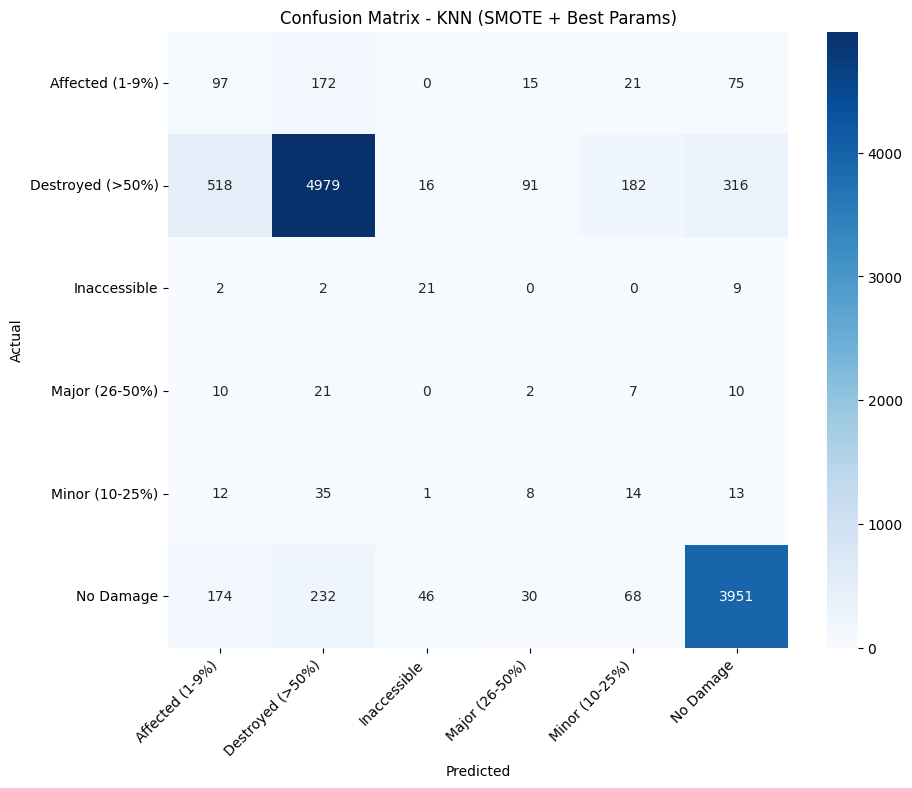

In [46]:
# KNN Implementation with SMOTE, Scaling and Best Params
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Apply SMOTE to Training Data Only
print("Applying SMOTE to training data...")
smote = SMOTE(random_state=42)
attr_train_res, target_train_res = smote.fit_resample(attr_train, target_train)

# Round to nearest int to keep categorical nature valid
attr_train_res = np.round(attr_train_res).astype(int)

# Scaling (Fit on Resampled Training Data)
scaler = MinMaxScaler()
attr_train_scaled = scaler.fit_transform(attr_train_res)
attr_test_scaled = scaler.transform(attr_test)

# # Grid Search (Commented out as requested)
# print("Starting Grid Search for KNN...")
# param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
# grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, n_jobs=1, verbose=1)
# grid_knn.fit(attr_train_scaled, target_train_res)
# print(f"Best KNN Parameters: {grid_knn.best_params_}")
# target_pred = grid_knn.predict(attr_test_scaled)

# Using Best Parameters directly
print("Training KNN with best parameters (n_neighbors=3, weights='distance')...")
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(attr_train_scaled, target_train_res)
target_pred = knn.predict(attr_test_scaled)

# Decode for report
target_test_decoded = le_target.inverse_transform(target_test)
target_pred_decoded = le_target.inverse_transform(target_pred)
labels = le_target.classes_

# Evaluation
print("KNN Classification Report (with SMOTE):")
print(classification_report(target_test_decoded, target_pred_decoded))

# Confusion Matrix
cm = confusion_matrix(target_test_decoded, target_pred_decoded, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - KNN (SMOTE + Best Params)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.show()

K-Nearest Neighbors (KNN) is a distance-based classifier that predicts damage by finding the most similar examples in the training set; here, we use SMOTE to balance the classes and `weights='distance'` to prioritize closer neighbors. Our accurary is 83%, but improved recall for minority classes

# CART

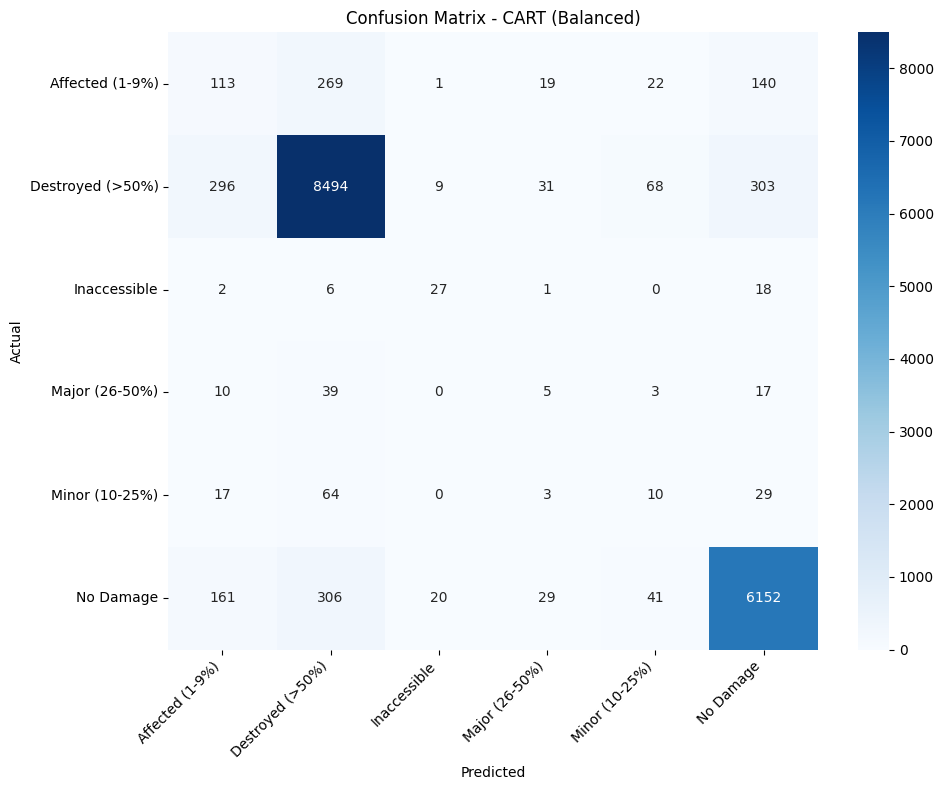

                  precision    recall  f1-score   support

 Affected (1-9%)       0.19      0.20      0.19       564
Destroyed (>50%)       0.93      0.92      0.92      9201
    Inaccessible       0.47      0.50      0.49        54
  Major (26-50%)       0.06      0.07      0.06        74
  Minor (10-25%)       0.07      0.08      0.07       123
       No Damage       0.92      0.92      0.92      6709

        accuracy                           0.88     16725
       macro avg       0.44      0.45      0.44     16725
    weighted avg       0.89      0.88      0.89     16725



In [47]:
# Using a label encoder here because using the get_dummies() method takes too much memory and crashes the kernel.
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


df_encoded = opt_attr.copy()
le_target = LabelEncoder()

# Fit and save the target encoder
le_target.fit(df_obj['* Damage'].astype(str))


# Encode all columns
for col in df_encoded.columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# attr = df_encoded.drop(['* Damage'], axis=1)
# target = df_encoded['* Damage']

attr_train, attr_test, target_train, target_test = train_test_split(attr, target, test_size=0.3, random_state=6)

# Added class_weight='balanced' to handle class imbalance
model = DecisionTreeClassifier()
model.fit(attr_train, target_train)
target_pred = model.predict(attr_test)

# Decode predictions and targets
target_test_decoded = le_target.inverse_transform(target_test)
target_pred_decoded = le_target.inverse_transform(target_pred)

# Get class labels
labels = le_target.classes_

# Create confusion matrix
cm = confusion_matrix(target_test_decoded, target_pred_decoded, labels=labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CART (Balanced)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(classification_report(target_test_decoded, target_pred_decoded))

Using the CART method, we see that our model is 89% accurate. We can also see that most of our data either falls into "No Damage" or "Destroyed". There is significantly less data for any other categories.

# Naive Bayes


Training CategoricalNB with best parameters (alpha=1.0)...

Naive Bayes Classification Report:
                  precision    recall  f1-score   support

 Affected (1-9%)       0.14      0.18      0.16       380
Destroyed (>50%)       0.94      0.75      0.84      6102
    Inaccessible       0.07      0.71      0.13        34
  Major (26-50%)       0.03      0.24      0.05        50
  Minor (10-25%)       0.04      0.13      0.07        83
       No Damage       0.80      0.86      0.83      4501

        accuracy                           0.77     11150
       macro avg       0.34      0.48      0.35     11150
    weighted avg       0.85      0.77      0.80     11150



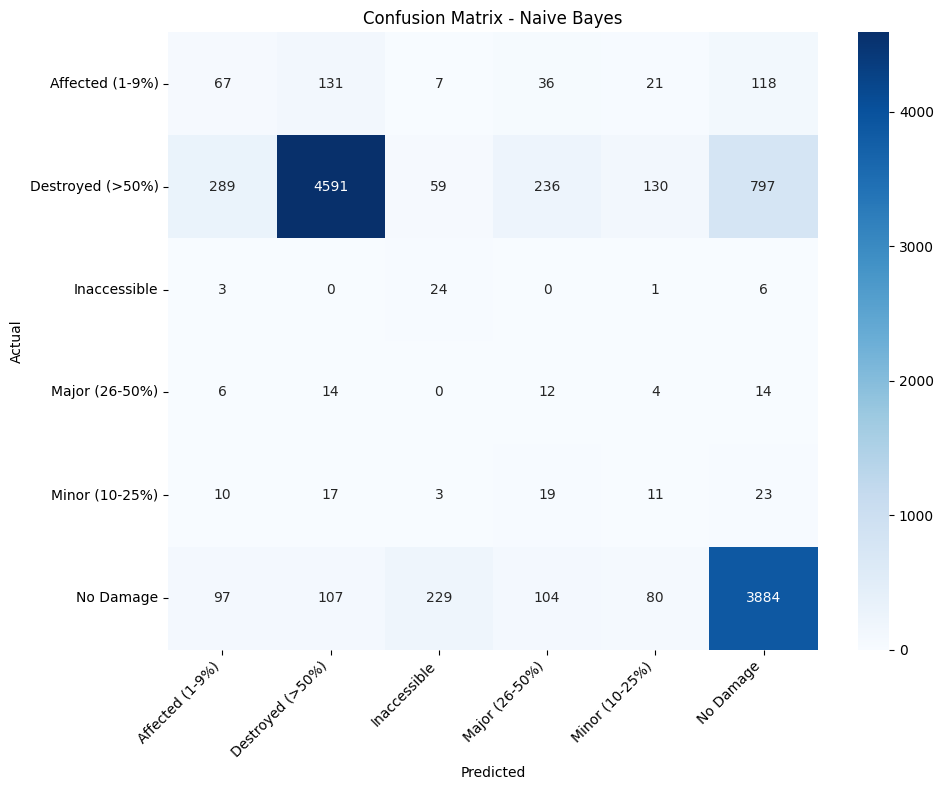

In [48]:
# Naive Bayes Implementation (with best parameters from tuning)
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split  # , GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Encode the data (similar to CART approach)
# Use LabelEncoder on each column to convert to non-negative integers
df_encoded_nb = opt_attr.copy()

for col in df_encoded_nb.columns:
    le = LabelEncoder()
    df_encoded_nb[col] = le.fit_transform(df_encoded_nb[col].astype(str))

# 2. Split Data (80-20 split)
attr_train_nb, attr_test_nb, target_train_nb, target_test_nb = train_test_split(
    df_encoded_nb, target, test_size=0.2, random_state=6
)

# 3. Compute sample weights for class balancing
sample_weights = compute_sample_weight(class_weight='balanced', y=target_train_nb)

# 4. Calculate min_categories from the full encoded dataset
min_categories = [int(df_encoded_nb[col].max() + 1) for col in df_encoded_nb.columns]

# # 5. Hyperparameter Tuning with GridSearchCV (COMMENTED OUT - using best params below)
# print("Performing hyperparameter tuning for CategoricalNB...")
# param_grid = {
#     'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
# }
# 
# nb_base = CategoricalNB(min_categories=min_categories)
# grid_search = GridSearchCV(
#     nb_base, 
#     param_grid, 
#     cv=5, 
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )
# 
# grid_search.fit(attr_train_nb, target_train_nb, sample_weight=sample_weights)
# 
# print(f"\nBest parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
# 
# nb = grid_search.best_estimator_

# 5. Train model with best parameters (from grid search: alpha=1.0)
print("Training CategoricalNB with best parameters (alpha=1.0)...")
nb = CategoricalNB(alpha=0.01, min_categories=min_categories)
nb.fit(attr_train_nb, target_train_nb, sample_weight=sample_weights)

# 6. Predict
target_pred_nb = nb.predict(attr_test_nb)

# 7. Evaluate
# Decode targets for readable report
target_test_decoded = le_target.inverse_transform(target_test_nb)
target_pred_decoded = le_target.inverse_transform(target_pred_nb)

print("\nNaive Bayes Classification Report:")
print(classification_report(target_test_decoded, target_pred_decoded))

# Confusion Matrix
cm_nb = confusion_matrix(target_test_decoded, target_pred_decoded, labels=le_target.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Naive Bayes is a probabilistic classifier based on Bayes' theorem; we use `CategoricalNB` suitable for our labeled data and apply SMOTE to improve the detection of rare damage categories. Our accurary is 73%, but improved recall for minority classes

# Decision Trees


Decision Trees Classification Report:
                  precision    recall  f1-score   support

 Affected (1-9%)       0.39      0.07      0.12       564
Destroyed (>50%)       0.95      0.85      0.90      9201
    Inaccessible       0.00      0.00      0.00        54
  Major (26-50%)       0.00      0.00      0.00        74
  Minor (10-25%)       0.00      0.00      0.00       123
       No Damage       0.79      0.99      0.88      6709

        accuracy                           0.87     16725
       macro avg       0.35      0.32      0.32     16725
    weighted avg       0.85      0.87      0.85     16725



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


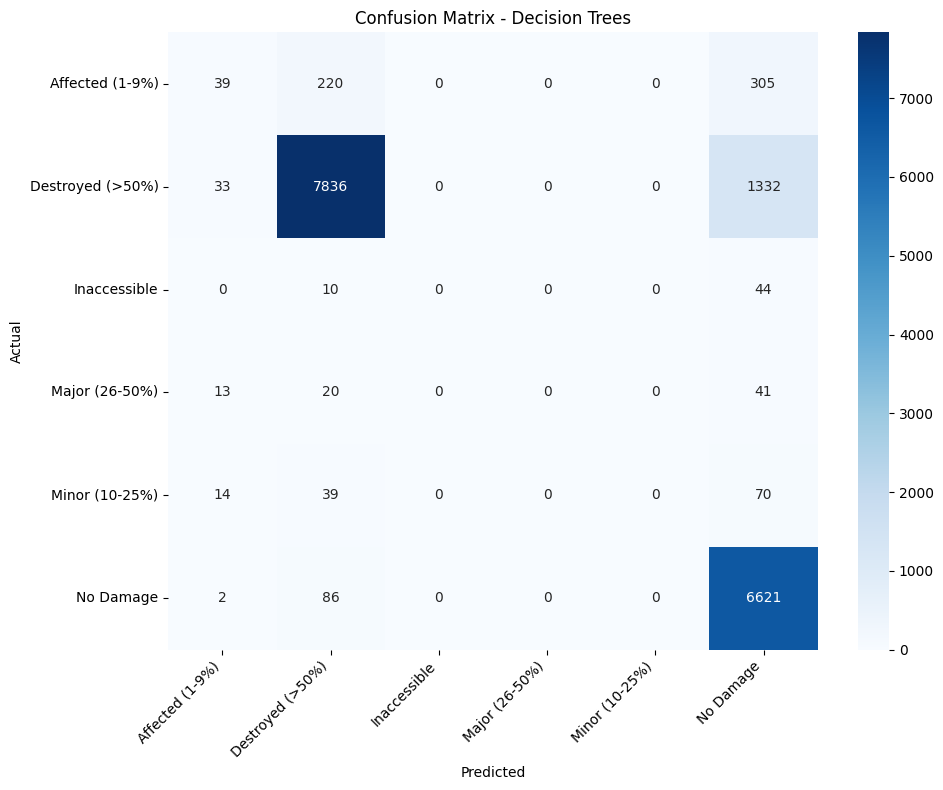

In [49]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


#Splitting
attr_train_c5, attr_test_c5, target_train_c5, target_test_c5 = train_test_split(attr, target, test_size=0.3, random_state=6)

#C5
c50 = DecisionTreeClassifier(max_depth=4, random_state=42)
c50.fit(attr_train_c5, target_train_c5)
target_pred_c5 = c50.predict(attr_test_c5)

#Evaluate
target_test_decoded = le_target.inverse_transform(target_test_c5)
target_pred_decoded = le_target.inverse_transform(target_pred_c5)

print("\nDecision Trees Classification Report:")
print(classification_report(target_test_decoded, target_pred_decoded))

#Confusion Matrix
cm_nb = confusion_matrix(target_test_decoded, target_pred_decoded, labels=le_target.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Trees')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Using the C5 Decision Trees, we see that our model is 87% accurate. We can also see that most of our data either falls into "Destroyed", with "No Damage" coming at a close second. Other categories have less data

# ANN


ANN Classification Report:
                  precision    recall  f1-score   support

 Affected (1-9%)       0.00      0.00      0.00       592
Destroyed (>50%)       0.88      0.84      0.86      9129
    Inaccessible       0.00      0.00      0.00        54
  Major (26-50%)       0.00      0.00      0.00        74
  Minor (10-25%)       0.00      0.00      0.00       135
       No Damage       0.78      0.92      0.84      6741

        accuracy                           0.83     16725
       macro avg       0.28      0.29      0.28     16725
    weighted avg       0.79      0.83      0.81     16725



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


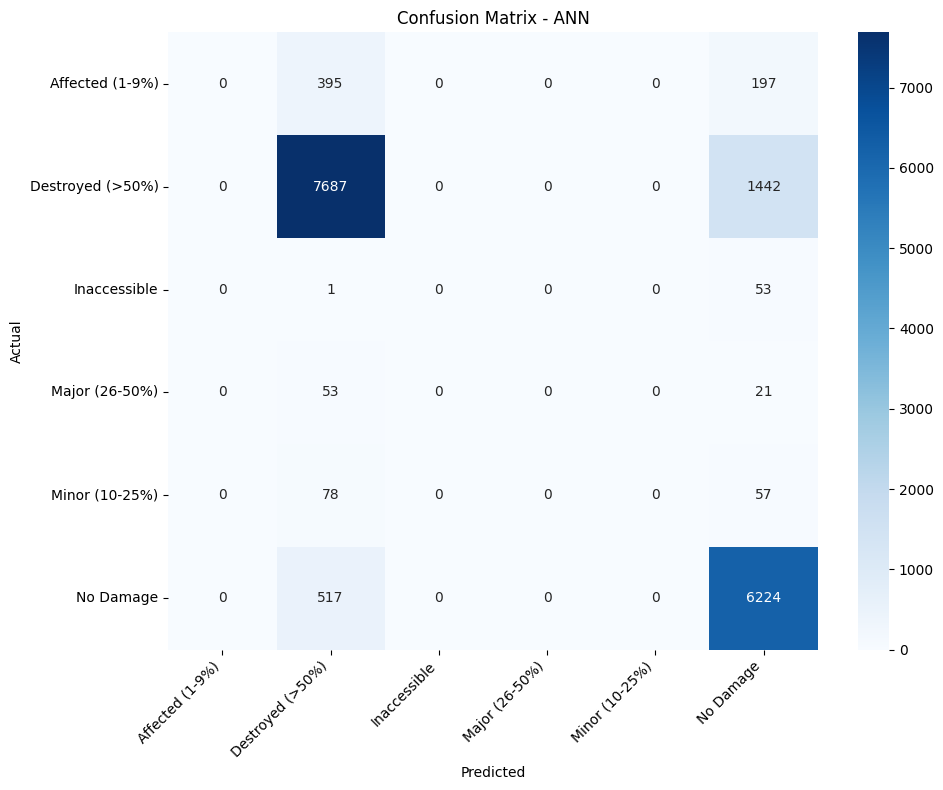

In [50]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

#Normalizing the data
scaler = StandardScaler()
attr_ann = pd.DataFrame(
    scaler.fit_transform(opt_attr.copy()),
    columns=opt_attr.columns
)

#Splitting the data
attr_train_ann, attr_test_ann, target_train_ann, target_test_ann = train_test_split(attr_ann, target, random_state=82, test_size=0.3)

#ANN
model = MLPClassifier(hidden_layer_sizes=(5,), max_iter=10000)
model.fit(attr_train_ann, target_train_ann)
target_pred_ann = model.predict(attr_test_ann)

#Evaluate
target_test_decoded = le_target.inverse_transform(target_test_ann)
target_pred_decoded = le_target.inverse_transform(target_pred_ann)

print("\nANN Classification Report:")
print(classification_report(target_test_decoded, target_pred_decoded))

#Confusion Matrix
cm_nb = confusion_matrix(target_test_decoded, target_pred_decoded, labels=le_target.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Using the ANN method, we see that our model is 83% accurate. Like before, we can also see that most of our data into "Destroyed", with "No Damage" the second most. There is  less data for any other categories.

# HClust

In [51]:
# Code here

# KMeans

In [52]:
# Code here